# Project 3a

The final part of the project will ask you to perform your own data science project to classify a new dataset.

## Submission Details

**Project is due June 14th at 11:59 pm (Friday Midnight). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend printing the notebook using [$\LaTeX$](https://www.latex-project.org/)**

## Loading Essentials and Helper Functions

In [33]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

In [34]:
#Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
%cd '/content/drive/MyDrive/CM148_Project3'

/content/drive/MyDrive/CM148_Project3


In [36]:
# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

import sys
sys.path.append('/content/drive/MyDrive/CM148_Project3')

import helper as hel
from helper import draw_confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

## Background: Dataset Information (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (male/female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [37]:
# Preprocess Data

# Load Data
data = pd.read_csv("/content/drive/MyDrive/CM148_Project3/datasets/heartdisease.csv")

# Transform target feature into numerical
le = LabelEncoder()
data["target"] = le.fit_transform(data["sick"])
data["sex"] = le.fit_transform(data["sex"])
data = data.drop(["sick"], axis=1)

# Split target and data
y = data["target"]
x = data.drop(["target"], axis=1)
original_feature_names = x.columns.tolist()

# Train test split
# 40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(
    x, y, test_size=0.4, stratify=y, random_state=0
)

# Feature Transformation
# This is the only change from project 2 since we replaced standard scaler to minmax
# This was done to ensure that the numerical features were still of the same scale
# as the one hot encoded features
num_pipeline = Pipeline([("minmax", MinMaxScaler())])

heart_num = train_raw.drop(
    ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"], axis=1
)
numerical_features = list(heart_num)
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories="auto"), categorical_features),
    ]
)

# Transform raw data
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)  # Note that there is no fit calls

# Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [38]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [39]:
# Baseline accuracy of using the majority class
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print(
    "==========================================",
    "\nBaseline Accuraccy of using Majority Class:",
    np.round(np.max(ct) / np.sum(ct), 3),
)

Counts of each class in target_test: 
target
0    66
1    56
Name: count, dtype: int64
Baseline Accuraccy of using Majority Class: 0.541


## 1. (25 pts) Decision Trees

### 1.1. [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use `random_state = SEED` so that your results match ours.

In [40]:
# TODO
decision_tree = DecisionTreeClassifier(random_state=SEED)
decision_tree.fit(train, target)
prediction = decision_tree.predict(test)
acc=metrics.accuracy_score(target_test, prediction)
acc

0.7131147540983607

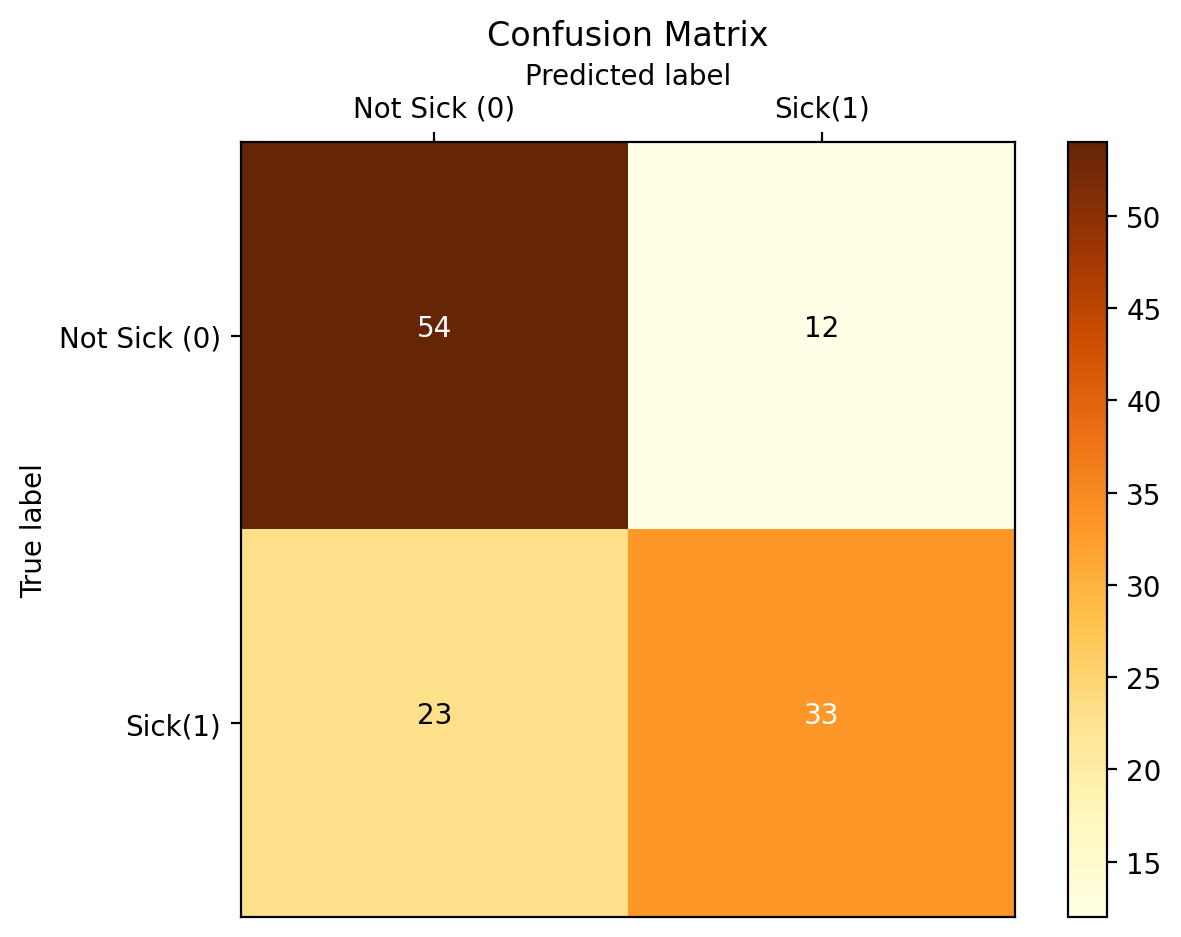

In [41]:
#Printing confusion matrix
hel.draw_confusion_matrix(target_test, prediction, ["Not Sick (0)", "Sick(1)"])

### 1.2. [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

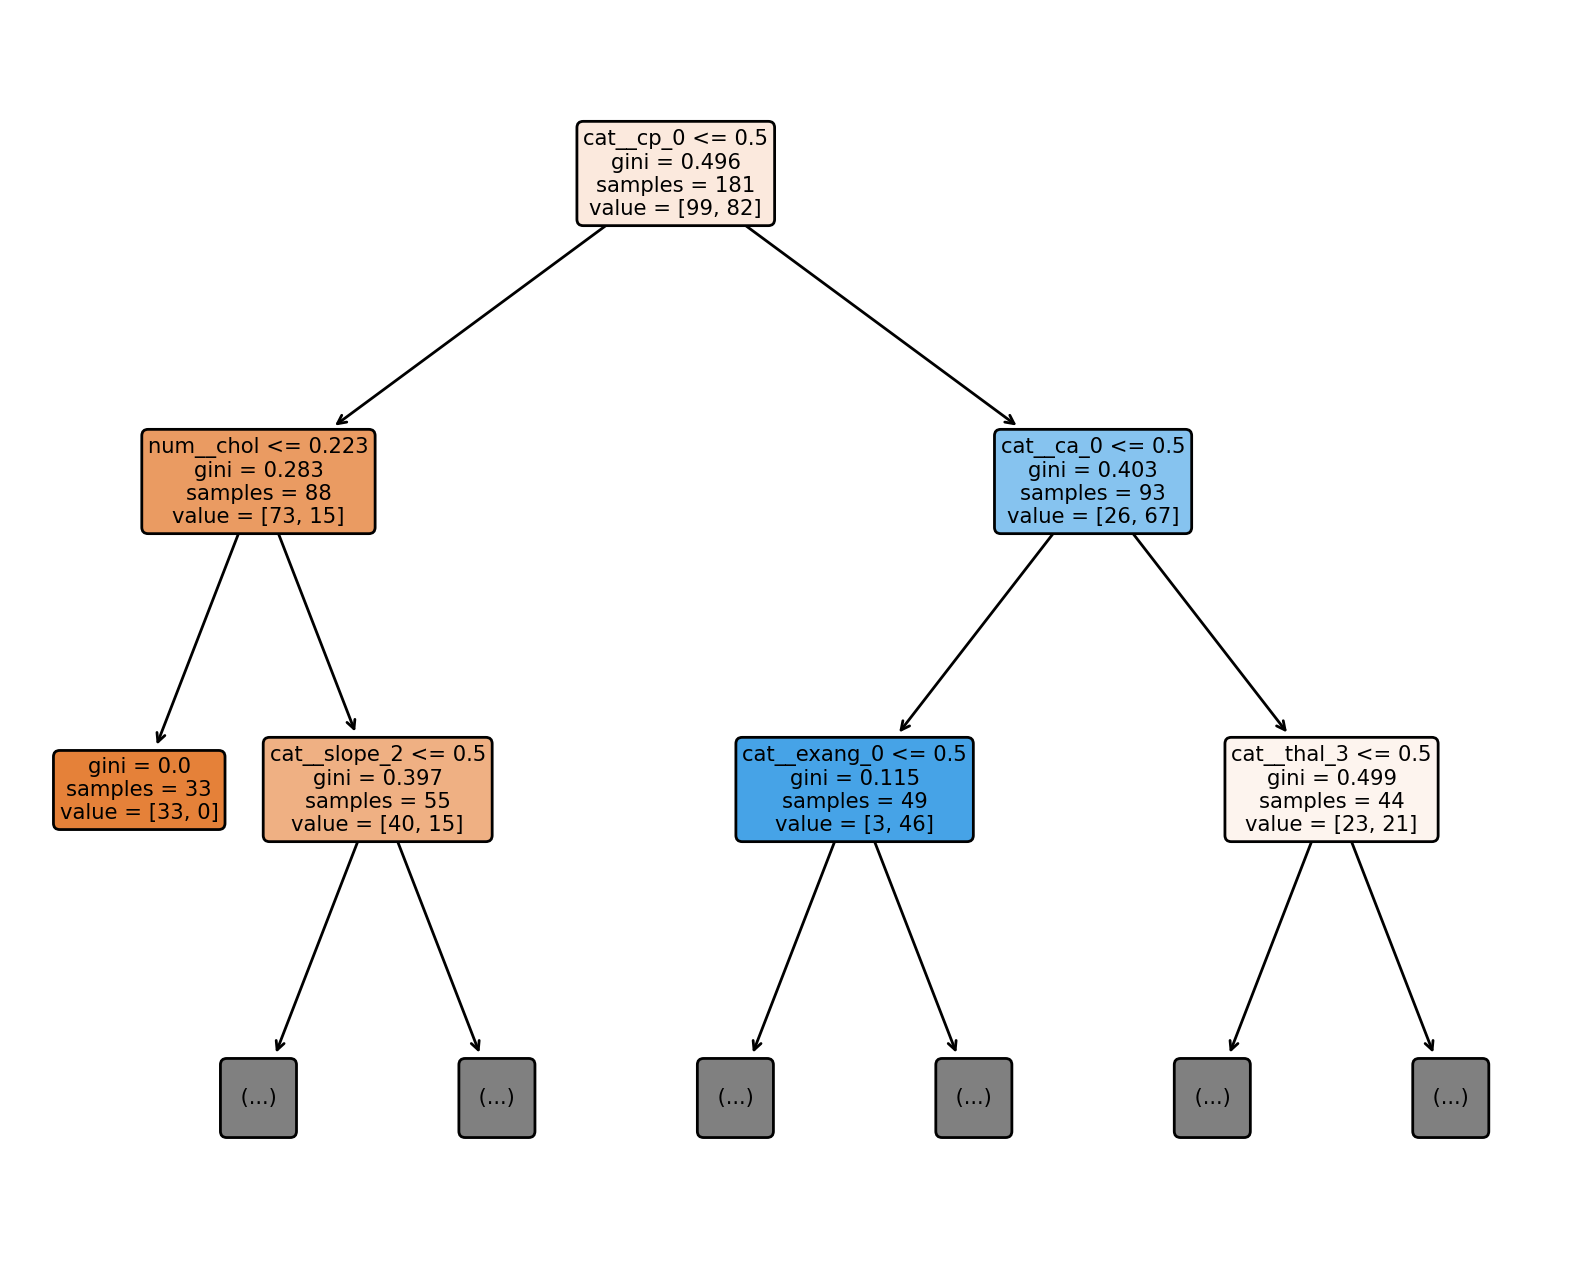

In [42]:
# TODO
plt.figure(figsize=(10,8))
tree.plot_tree(decision_tree, filled=True, max_depth=2, rounded=True, feature_names=feature_names)
plt.show()

**What is the gini index improvement of the first split?**

Response:

Gini index of parent = 0.496
Gini index of right child = 0.403
Gini index of left child = 0.283

$$ \text{Gini Index Improvement} = 0.496 - \frac{93}{181}\cdot 0.403 - \frac{88}{181}\cdot 0.283 = 0.1513425414  \approx 0.151$$

### 1.3 [5 pts] Plot the importance of each feature for the Decision Tree

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (10,) and arg 3 with shape (13,).

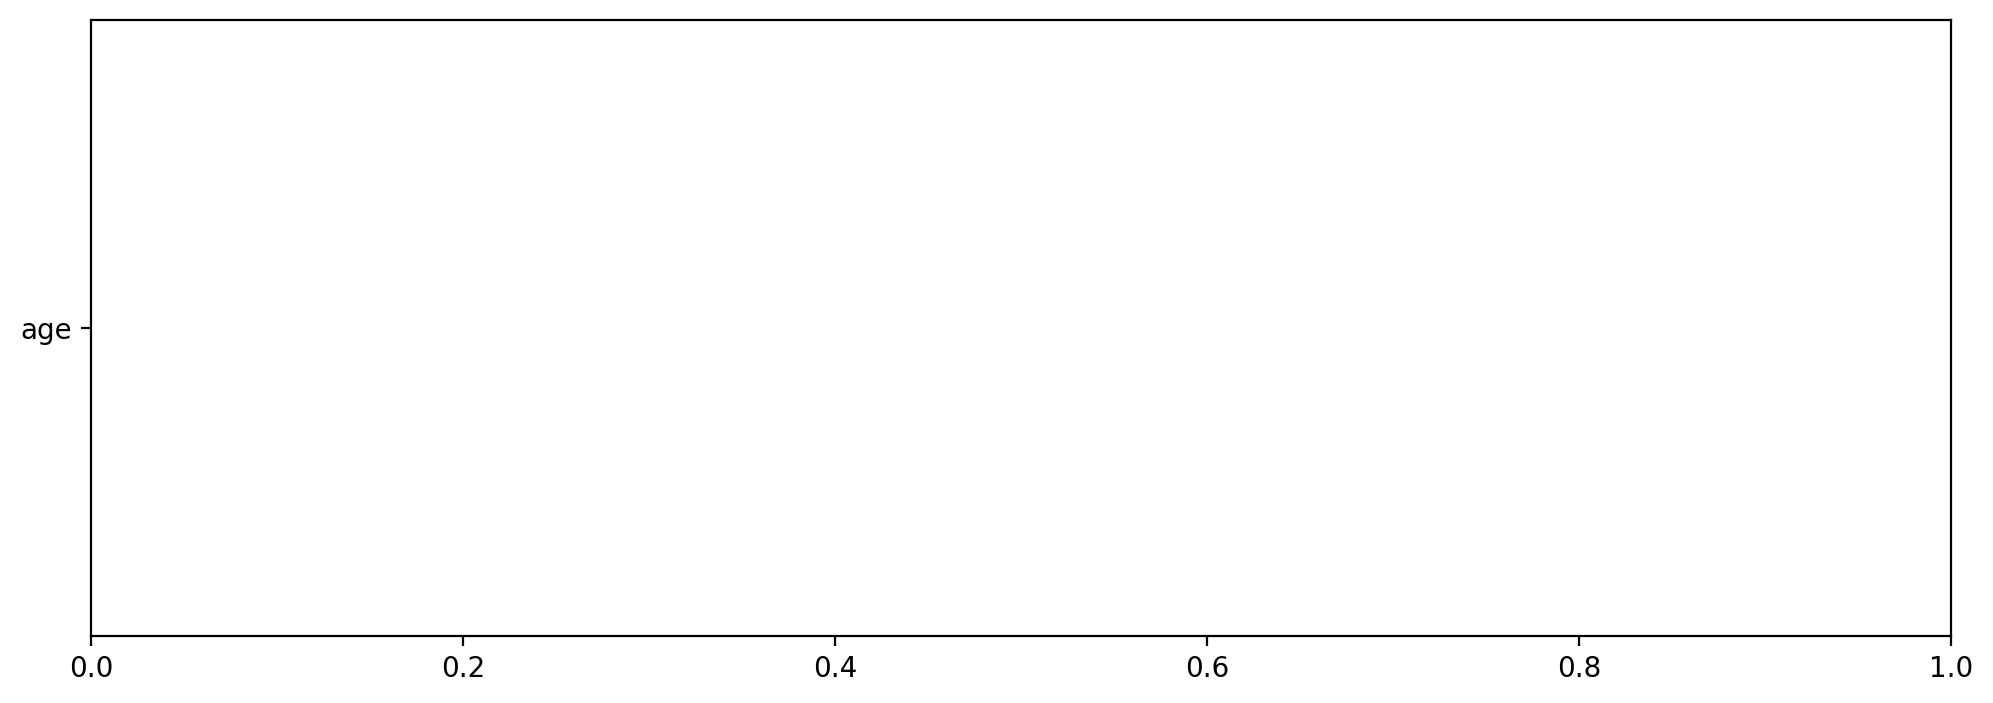

In [75]:
# TODO
feature_importances = decision_tree.feature_importances_
feature_names =

plt.figure(figsize=(12,4))
plt.barh(original_feature_names, feature_importances)
plt.xlabel('Feature Name')
plt.ylabel('Importance')
plt.title("Importance of Features in Decision Tree")
plt.show()

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?**

Response: All except 1 have non-zero importance for the decision tree. If we remove features with zero importance, it is unlikely to change the decision tree for the same sampled dataset since these features are not very significant in the decision tree formation.

### 1.4 [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a `GridSearchCV` with 5-Fold Cross Validation for the Decision Tree. Find the best model parameters for accuracy amongst the following:

- `max_depth` = [2, 4, 8, 16, 32]
- `min_samples_split` = [2, 4, 8, 16]
- `criterion` = [`gini`, `entropy`]

After using `GridSearchCV`, Print the **best 5 models** with the following parameters: `rank_test_score`, `param_max_depth`, `param_min_samples_split`, `param_criterion`, `mean_test_score`, `std_test_score`.


In [47]:
# TODO
#DOUBT: Do we set random state to seed here?
parameters = [
    {
        "max_depth": [2,4,8,16,32],
        "min_samples_split": [2,4,8,16],
        "criterion": ["gini", "entropy"],
        "random_state":[SEED]
    }
]

k = 5
kf = KFold(n_splits=k, random_state=None)

decision_tree = DecisionTreeClassifier()
grid = GridSearchCV(decision_tree, parameters, cv=kf, scoring="accuracy")
grid.fit(train_raw, target)
res = pd.DataFrame(grid.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006913,0.003315,0.003260,0.000315,gini,2,2,42,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.648649,0.638889,0.694444,0.861111,0.666667,0.701952,0.081794,30
1,0.004627,0.000212,0.003186,0.000134,gini,2,4,42,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.648649,0.638889,0.694444,0.861111,0.666667,0.701952,0.081794,30
2,0.004782,0.000088,0.003389,0.000184,gini,2,8,42,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.648649,0.638889,0.694444,0.861111,0.666667,0.701952,0.081794,30
3,0.004878,0.000189,0.003484,0.000399,gini,2,16,42,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.648649,0.638889,0.694444,0.861111,0.666667,0.701952,0.081794,30
4,0.005805,0.001825,0.003249,0.000090,gini,4,2,42,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.648649,0.666667,0.777778,0.888889,0.722222,0.740841,0.086753,15
5,0.005018,0.000705,0.003366,0.000148,gini,4,4,42,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.648649,0.666667,0.777778,0.888889,0.722222,0.740841,0.086753,15
6,0.004912,0.000194,0.003217,0.000078,gini,4,8,42,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.648649,0.666667,0.777778,0.888889,0.666667,0.729730,0.091835,23
7,0.004880,0.000165,0.003272,0.000128,gini,4,16,42,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.729730,0.666667,0.805556,0.888889,0.694444,0.757057,0.080708,6
8,0.004980,0.000063,0.003230,0.000129,gini,8,2,42,"{'criterion': 'gini', 'max_depth': 8, 'min_sam...",0.729730,0.750000,0.777778,0.861111,0.694444,0.762613,0.056248,3
9,0.005571,0.001486,0.004325,0.002204,gini,8,4,42,"{'criterion': 'gini', 'max_depth': 8, 'min_sam...",0.702703,0.750000,0.750000,0.861111,0.694444,0.751652,0.059423,7


In [48]:
res_sorted = res.sort_values(by='mean_test_score', ascending=False)
wanted_params = ["rank_test_score", "param_max_depth", "param_min_samples_split", "param_criterion", "mean_test_score", "std_test_score"]
for i in range(4):
  print("Rank:", i+1)
  print("Score:", res_sorted.iloc[i]['mean_test_score'])
  print("Parameters:", res_sorted.iloc[0]['params'])
  for p in wanted_params:
    value = res_sorted.iloc[i][p]
    print(f"{p}:{value}")
  print("   ")

Rank: 1
Score: 0.7681681681681681
Parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'random_state': 42}
rank_test_score:1
param_max_depth:16
param_min_samples_split:2
param_criterion:gini
mean_test_score:0.7681681681681681
std_test_score:0.06619459242573181
   
Rank: 2
Score: 0.7681681681681681
Parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'random_state': 42}
rank_test_score:1
param_max_depth:32
param_min_samples_split:2
param_criterion:gini
mean_test_score:0.7681681681681681
std_test_score:0.06619459242573181
   
Rank: 3
Score: 0.7626126126126126
Parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'random_state': 42}
rank_test_score:3
param_max_depth:8
param_min_samples_split:2
param_criterion:gini
mean_test_score:0.7626126126126126
std_test_score:0.05624801787788499
   
Rank: 4
Score: 0.7572072072072071
Parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'random_state': 42}
rank_test_s

**Using the best model you have, report the test accuracy and print out the confusion matrix**

In [49]:
# TODO
best_model = DecisionTreeClassifier(criterion='gini', max_depth=16, min_samples_split=2, random_state=SEED)
best_model.fit(train_raw, target)
predicted = best_model.predict(test_raw)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))

Accuracy:    0.713115


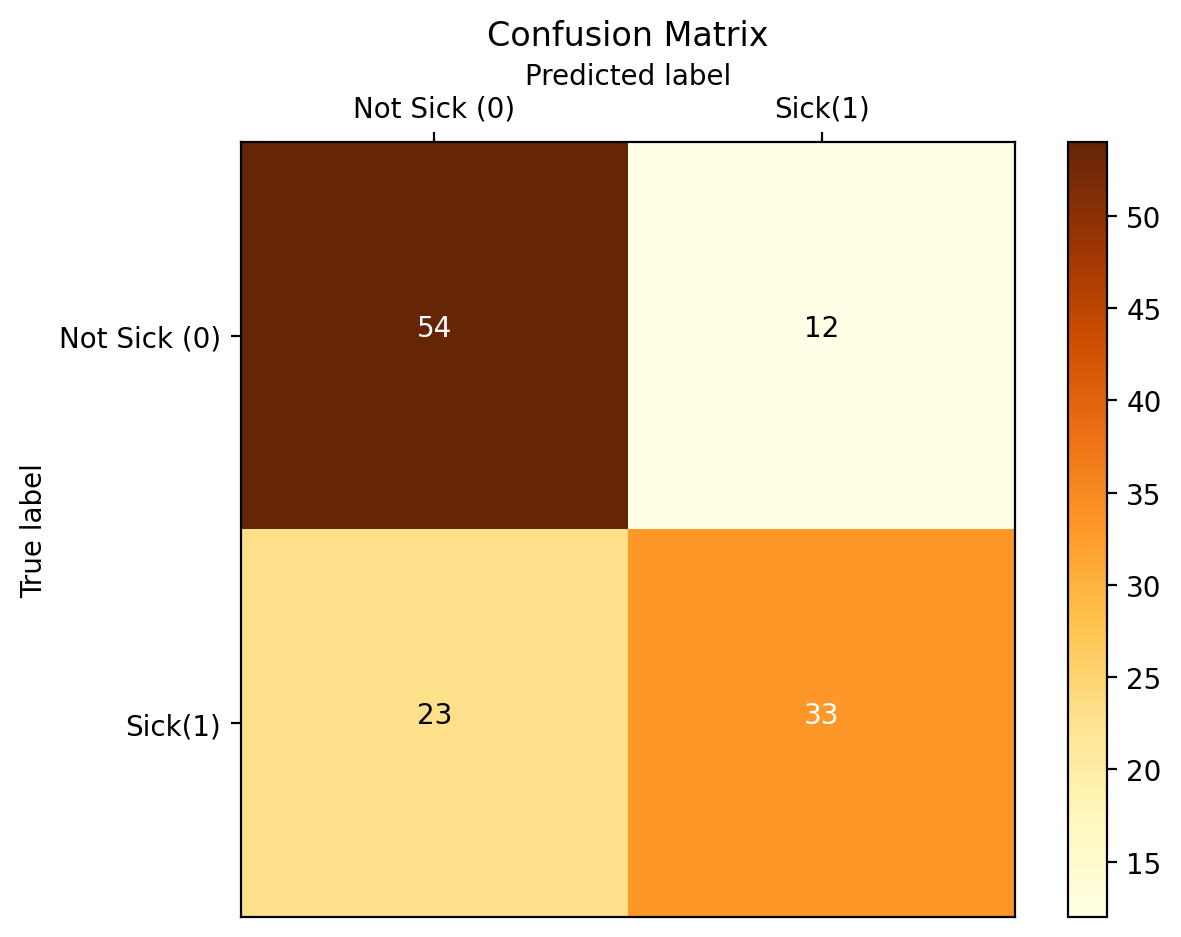

In [50]:
#Printing out the confusion matrix
hel.draw_confusion_matrix(target_test, predicted, ["Not Sick (0)", "Sick(1)"])

## 2. (20 pts) Multi-Layer Perceptron

### 2.1 [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with `hidden_layer_sizes=(50, 50)` and `max_iter = 1000`. **Report the accuracy and print the confusion matrix**. Make sure to set `random_state=SEED`.

In [51]:
# TODO
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)
mlp.fit(train_raw, target)
prediction = mlp.predict(test_raw)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,prediction)))

Accuracy:    0.803279


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


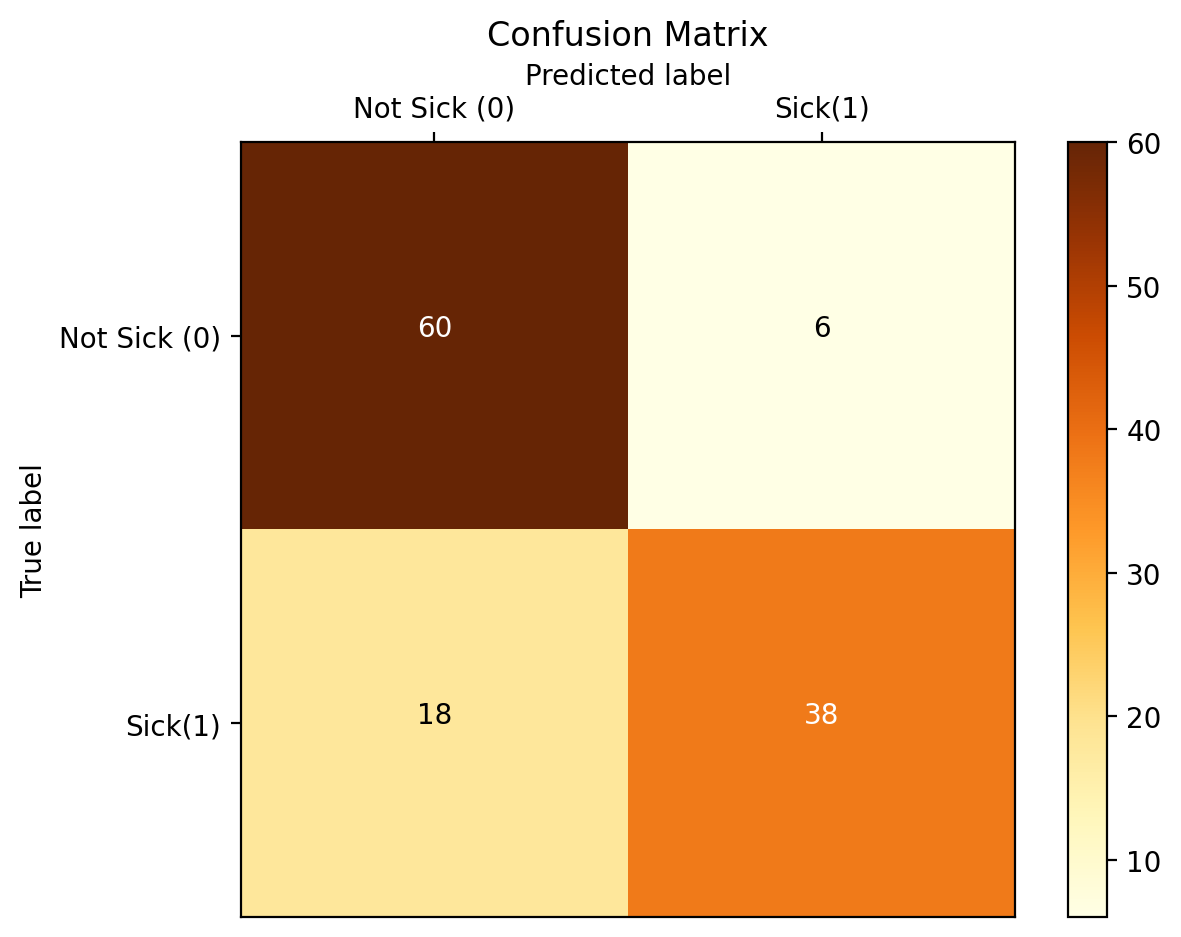

In [52]:
#Printing out the confusion matrix
hel.draw_confusion_matrix(target_test, prediction, ["Not Sick (0)", "Sick(1)"])

### 2.2 [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code.
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [53]:
# TODO
#DOUBT: Do we use random_state=SEED throughout the project or only where it is specified?
#DOUBT: Is it normal to get different results each time we rerun this cell?
import time
print("Decision Tree Classifier")
dt = DecisionTreeClassifier(random_state=SEED)
start = time.time()
dt.fit(train_raw, target)
end = time.time()
time_taken = (end-start)*1000
print("Time taken to fit:", round(time_taken,5), " milliseconds")
start = time.time()
dt.predict(test_raw)
end=time.time()
time_taken = (end-start)*1000
print("Time taken to predict:", round(time_taken,5), " milliseconds")

print("  ")

print("Multi-Layer Perceptron")
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)
start = time.time()
mlp.fit(train_raw, target)
end = time.time()
time_taken = (end-start)*1000
print("Time taken to fit:", round(time_taken,5), " milliseconds")
start = time.time()
mlp.predict(test_raw)
end=time.time()
time_taken = (end-start)*1000
print("Time taken to predict:", round(time_taken,5), " milliseconds")


Decision Tree Classifier
Time taken to fit: 5.89848  milliseconds
Time taken to predict: 1.71804  milliseconds
  
Multi-Layer Perceptron
Time taken to fit: 1433.23445  milliseconds
Time taken to predict: 4.6308  milliseconds


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Decision Trees were much quicker than the MLP.

### 2.3 [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

**Advantage**: MLP can model highly complex decision boundaries, making them better suited to capturing the intricacies of the relationships between features and labels. This makes MLPs particularly powerful in tasks involving image recognition, natural language processing, and other applications involving the representation of complex features.

**Disadvantage**: MLPs typically require more computational resources during training than decision trees. Additionally, MLPs often require careful tuning of hyperparameters such as learning rate, number of layers, and number of neurons per layer, which can be a complex and time-consuming process. In contrast, decision trees are generally faster to train and require less computational power.

## 3 (35 pts) PCA

### 3.1 [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [55]:
# TODO
pca = PCA(n_components=10, random_state=SEED)
pca.fit(train)
pca.components_

array([[ 6.09946635e-02,  4.03486405e-02,  1.92458119e-02,
        -1.01732201e-01,  1.10715411e-01, -1.23314342e-01,
         1.23314342e-01,  3.42653325e-01, -1.34589184e-01,
        -2.09361216e-01,  1.29707586e-03, -1.28849271e-02,
         1.28849271e-02,  1.96937289e-01, -1.98556306e-01,
         1.61901735e-03, -3.50544191e-01,  3.50544191e-01,
         4.59558653e-02,  2.94123242e-01, -3.40079107e-01,
        -2.05535178e-01,  7.46326307e-02,  8.34805264e-02,
         6.75833376e-02, -2.01613171e-02, -3.90382012e-04,
         4.43852832e-02, -3.14081117e-01,  2.70086216e-01],
       [ 5.23178867e-02,  2.89025067e-02,  3.82650356e-02,
        -7.33246302e-03, -3.72850287e-03,  4.44422145e-01,
        -4.44422145e-01,  7.36224643e-02, -3.17147806e-02,
        -2.86078655e-02, -1.32998182e-02, -2.10653488e-02,
         2.10653488e-02,  4.25893739e-01, -4.44476340e-01,
         1.85826015e-02,  1.84907981e-02, -1.84907981e-02,
        -2.18311052e-02,  1.43545701e-01, -1.21714596e-

### 3.2 [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [56]:
# TODO
proportions = pca.explained_variance_ratio_
print("Percentage of variance explained by top 10 components:",round(np.sum(proportions)*100, 2), "%")

Percentage of variance explained by top 10 components: 87.72 %


### 3.3 [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [67]:
# TODO
train_pca = pca.fit_transform(train)
test_pca = pca.transform(test)

### 3.4 [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

In [68]:
# TODO
decision_tree = DecisionTreeClassifier()
decision_tree.fit(train_pca, target)
prediction = decision_tree.predict(test_pca)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,prediction)))

Accuracy:    0.803279


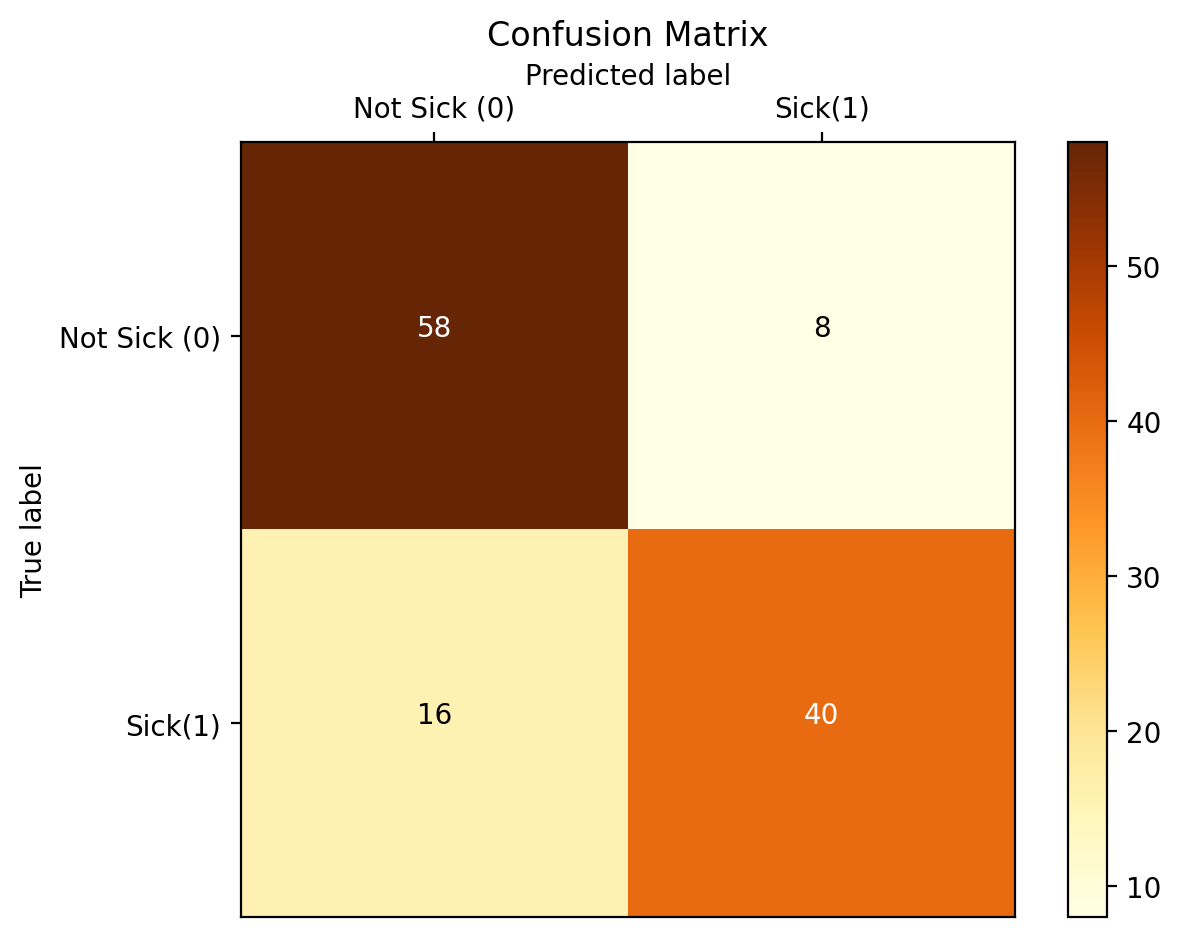

In [69]:
#Printing out the confusion matrix
hel.draw_confusion_matrix(target_test, prediction, ["Not Sick (0)", "Sick(1)"])

**Does the model perform better with or without PCA?**

Response: This model performs better without PCA since the accuracy for DT model is 0.70, but for the PCA model the accuracy is lower (0.68) REDO

### 3.5 [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

In [70]:
# TODO
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=1000, random_state=SEED)
mlp.fit(train_pca, target)
prediction = mlp.predict(test_pca)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,prediction)))

Accuracy:    0.803279


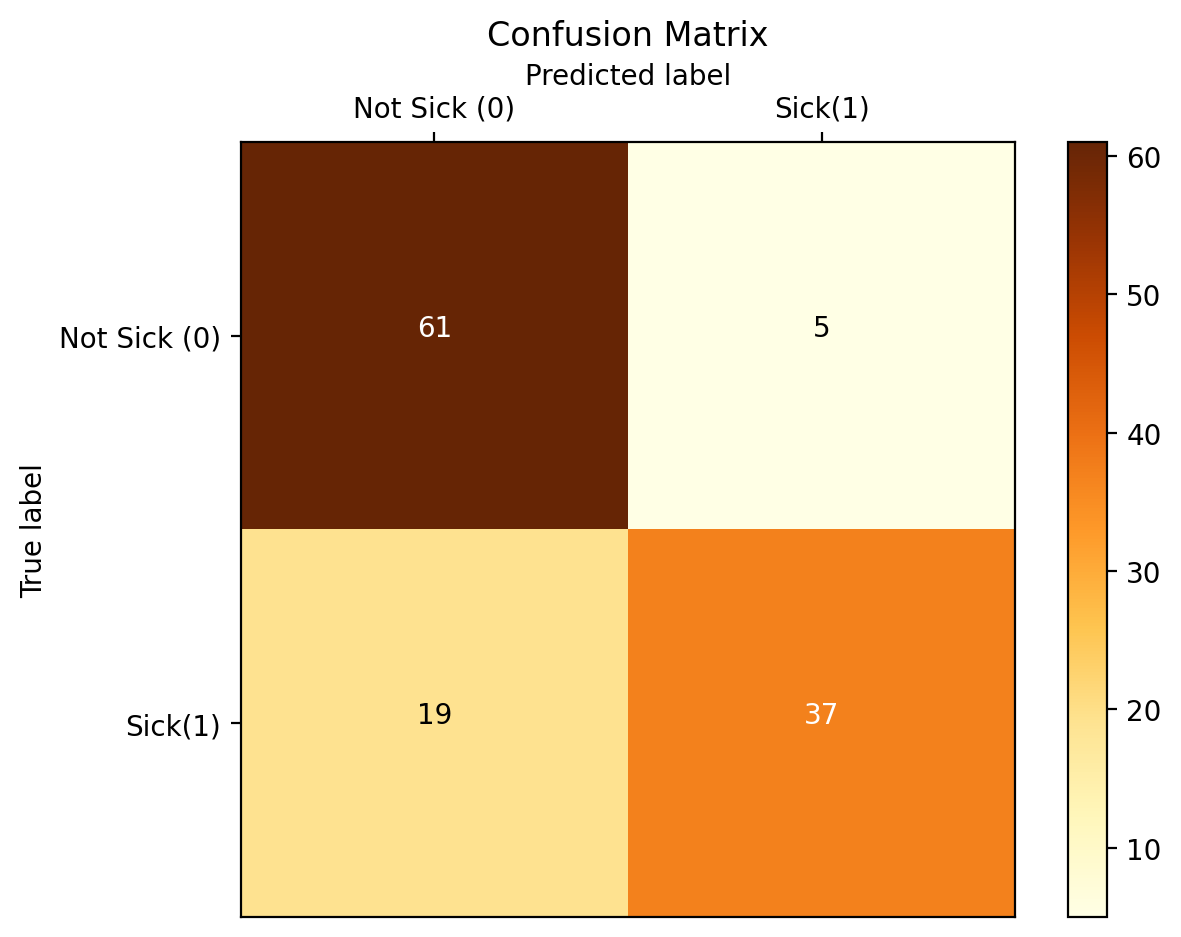

In [71]:
#Printing out the confusion matrix
hel.draw_confusion_matrix(target_test, prediction, ["Not Sick (0)", "Sick(1)"])

**Does the model perform better with or without PCA?**

Response: The model performs significantly better without PCA since the accuracy for the MLP classifier without PCA is 0.80, but with PCA it is 0.69. REDO

### 3.6 [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**






Pros:

*   Dimensionality Reduction: Reduces the dimensionality of the feature space while retaining most of the data variance, simplifying the dataset and making it easier to visualize and interpret.
*   Noise Reduction: By focusing only on the principal components of the data, PCA can help filter out noise from the data, improving the performance of the model.
*   Feature Extraction: PCA can be used to create new, uncorrelated features that can enhance the predictive power of models.

Cons:

*   Loss of Interpretability: Principal Components are linear combinations of original features and may not be easily interpretable.
*   Assumes Linearity: PCA assumes that the relationship between the features is linear. It may not be able to effectively capture complex, non-linear relationships between features.
*   Variance Centric: PCA focuses on components that explain the most variance, but these components may not always be the most important for the specific predictive task. Important but less varying features might be ignored.

*    Sensitivity to Scaling: PCA is sensitive to the relative scaling of the original features. If features are on different scales, PCA results can be misleading unless data is properly normalized or standardized.

## 4. (20 pts) K-Means Clustering

### 4.1 [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and `random_state = SEED`.

In [72]:
# TODO
kmeans_clustering = KMeans(random_state=SEED, n_clusters=5, n_init='auto')
kmeans_clustering.fit(train)
print("Inertia score:", kmeans_clustering.inertia_)

Inertia score: 499.7560851118564


### 4.2 [10 pts] Find the optimal cluster size using the elbow method.

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 25. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use `random_state = SEED`.

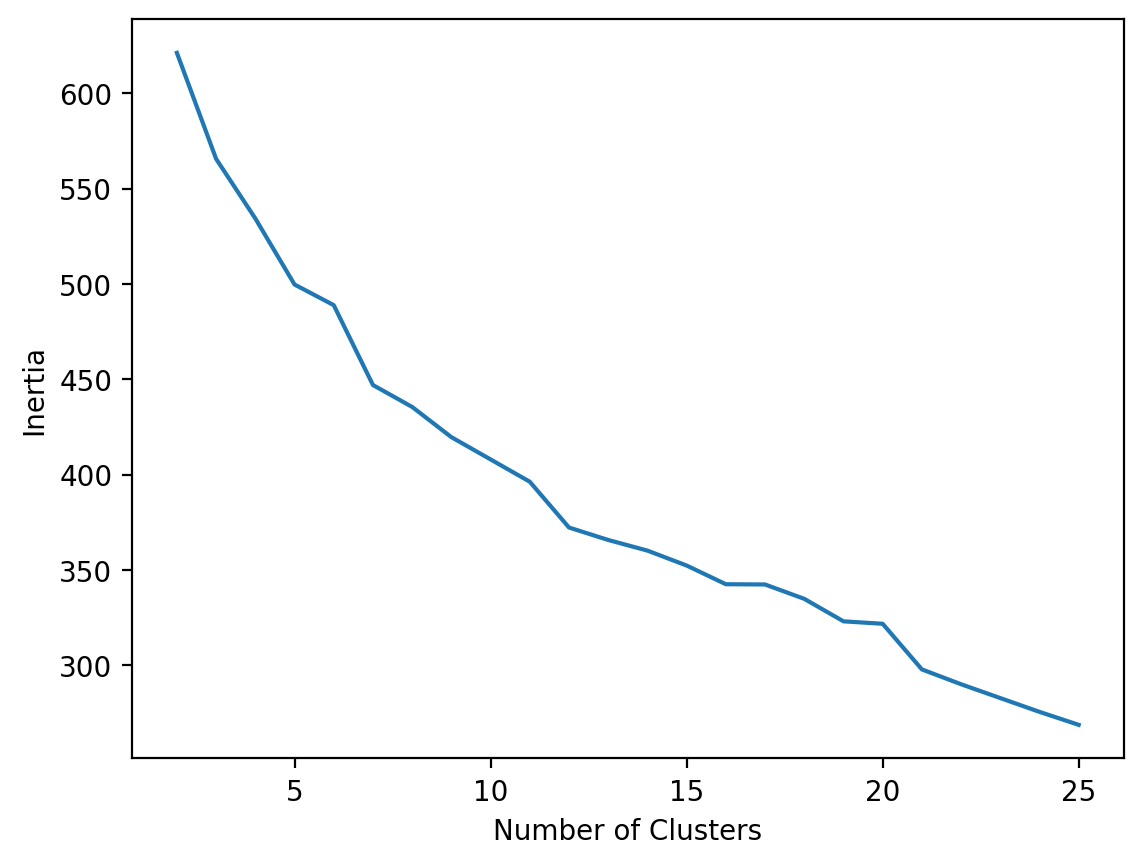

In [73]:
# TODO
inertia = []
n_cluster = []
for i in range(2,26):
  kmeans_clustering = KMeans(random_state=SEED, n_clusters=i, n_init='auto')
  kmeans_clustering.fit(train)
  n_cluster.append(i)
  inertia.append(kmeans_clustering.inertia_)


plt.plot(n_cluster, inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

From the plot, we can guess that the best cluster size is somewhere between 5 and 10.

### 4.3 [5 pts] Find the optimal cluster size for the train_pca data

Repeat the same experiment but use train_pca instead of train.

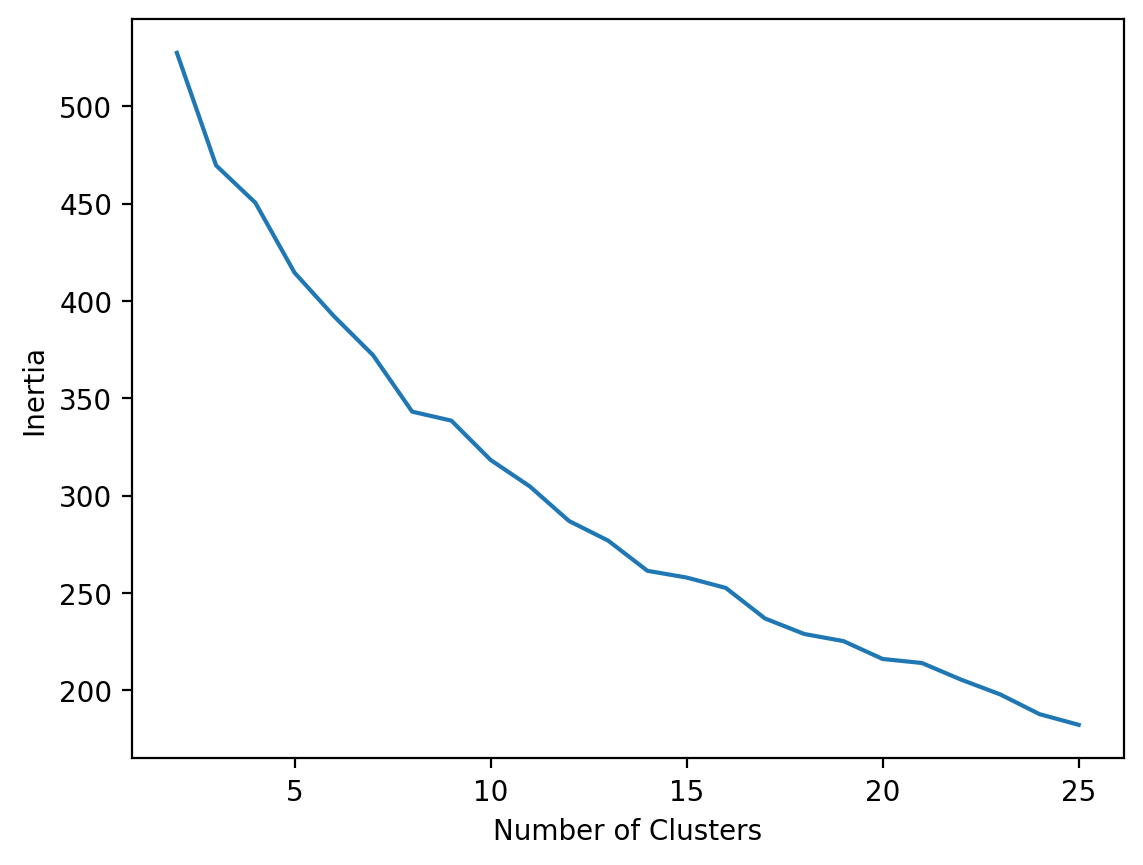

In [74]:
# TODO
inertia = []
n_cluster = []
for i in range(2,26):
  kmeans_clustering = KMeans(random_state=SEED, n_clusters=i, n_init='auto')
  kmeans_clustering.fit(train_pca)
  n_cluster.append(i)
  inertia.append(kmeans_clustering.inertia_)

plt.plot(n_cluster, inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Similar to the previous experiment, we can guess that the best cluster size is somewhere between 5 and 10. Additionally, we see that the inertia is much smaller for every cluster size when using PCA features.